In [20]:
import os
import polars as pl
import numpy as np
import datetime as dt
import aacgmv2
import contextlib
from spacepy import pycdf
import matplotlib.pyplot as plt

def calculate_magnetic_coords_aacgm(lat, lon, alt, timestamp):
    dtime = dt.datetime.utcfromtimestamp(timestamp)
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stderr(fnull): 
            geomag_lat, geomag_lon = aacgmv2.get_aacgm_coord(lat, lon, alt, dtime)[:2]
            if geomag_lat is None or geomag_lon is None:
                return np.nan, np.nan
            try:
                ut_hours = dtime.hour + dtime.minute / 60.0
                mlt = (geomag_lon / 15.0) + ut_hours
                mlt = mlt % 24  
                return geomag_lat, mlt
            except:
                return np.nan, np.nan 

In [ ]:
%%time

limit = 365  # Limit to this many CDF files for testing
champ_root_dir = "/Users/patrick/Dev/perceptive_techeval/data/champ-2002-2007/champ-2007/"

df_arr = []
processed = 0

for root, dirs, files in os.walk(os.path.abspath(champ_root_dir)):
    for file in [os.path.join(root, f) for f in files[0:limit] if f.endswith(".cdf")]:
        cdf = pycdf.CDF(file)
        alt = cdf["altitude"][:] / 1000.0
        lat = cdf["latitude"][:]
        lon = cdf["longitude"][:]
        lst = cdf["local_solar_time"][:]
        valid = cdf["validity_flag"][:]
        density = cdf["density"][:]
        density_orbitmean = cdf["density_orbitmean"][:]
        time = cdf["time"][:]

        unix_timestamps = [dt.datetime.timestamp(t) for t in time]

        df = pl.DataFrame({
            "timestamp": unix_timestamps,
            "altitude": alt,
            "latitude": lat,
            "longitude": lon,
            "local_solar_time": lst,
            "validity_flag": valid,
            "density_orbitmean": density_orbitmean,
            "density": density
        })

        columns_to_check = [col for col in df.columns if col != "timestamp"]

        df = df.with_columns([
            pl.when(pl.col(col) > 1e25).then(np.nan).otherwise(pl.col(col)).alias(col)
            for col in columns_to_check
        ])

        df_arr.append(df)
        processed += 1
        if processed >= limit:
            break

df = pl.concat(df_arr)

geomagnetic_latitudes, mlts = zip(*[
    calculate_magnetic_coords_aacgm(row[0], row[1], row[2], row[3])
    for row in zip(df["latitude"], df["longitude"], df["altitude"], df["timestamp"])
])

df = df.with_columns([
    pl.Series("geomagnetic_latitude", geomagnetic_latitudes),
    pl.Series("mlt", mlts)
])

df = df.with_columns(
    delta_density=(pl.col("density") - pl.col("density").rolling_mean(30)) / pl.col("density").rolling_mean(30)
)

df = df.filter(pl.col("validity_flag") == 0.0)

df = df.drop_nulls()
df.write_csv("df.csv")

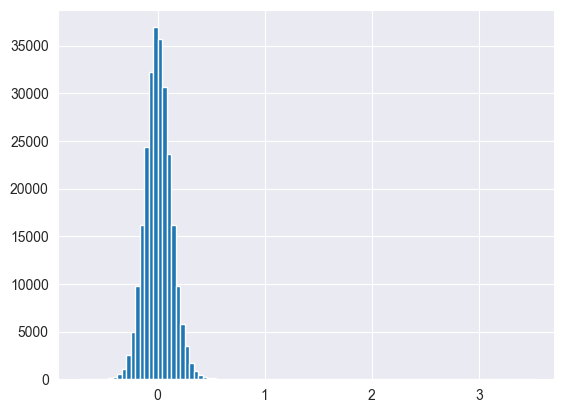

In [57]:
plt.hist(df["delta_density"],bins=100)
plt.show()

In [58]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = np.array(df["delta_density"])
X = np.array(df["altitude","geomagnetic_latitude","mlt","local_solar_time"])

mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))

reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

Mean Squared Error (MSE): 0.01621457317033758
Mean Absolute Error (MAE): 0.09725646335517031
R² Score: 0.006917584417851286


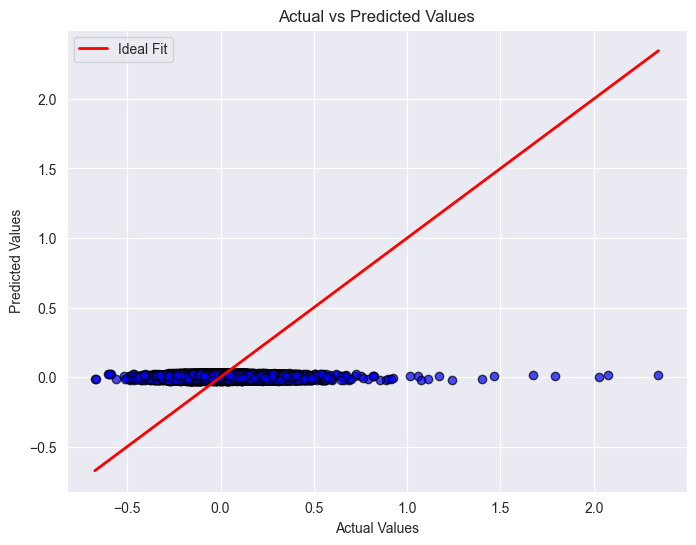

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()